In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.optimize import root_scalar
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y, gamma):
    r, dydtau = y
    dydtau2 = (2 * gamma - gamma**2)/(4 * (r**3)) - (1/(r**2)) - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return y_ta**4 - 4 * y_ta * (tau**2) + (2 * gamma - gamma**2) * (tau**2)
    factor = 0.635 * (1 + 0.01 * np.log10(1 + gamma))
    #print(factor)
    r_ta_initial = factor * (8 * (tau**2))**(1/3)
    sol = optimize.fsolve(expression, r_ta_initial, xtol=1e-10)[0]
    return sol





# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)



def yH_analytical(tau, y_i, tau_i):
    return (y_i / np.sqrt(tau_i)) * np.sqrt(tau)  

def j_fdm_hubble(t, y, gamma):
    r, dydtau = y
    dydtau2 = - r/(4 * (t**2))
    return [dydtau, dydtau2]


def yH_numerical(gamma, y_i):
    v_i = y_i / (2 * tau_i)
    y0 = [y_i, v_i]
    sol_yH = solve_ivp(j_fdm_hubble, [tau_i, tau_f], y0, args=(gamma,), 
                    method='RK45', t_eval=tau_arr, 
                    rtol=1e-5, atol=1e-5)
    return sol_yH 

def delta_analytical(tau_arr, y_i, tau_i, gamma):
    A = tau_i / y_i**2
    B = ((2 * gamma - gamma**2) * (tau_i**(3/2))) / (4 * (y_i**3))
    delta_vals = (- A * (tau_arr - tau_i) * np.log(np.abs(tau_arr / tau_i)) 
                  - 4 * B * (tau_arr**(-1/2) - tau_i**(-1/2)))
    return delta_vals


def delta_numerical(gamma, y_i):
    A = tau_i / y_i**2
    B = ((2 *gamma - gamma**2) * (tau_i**(3/2)))/(4 * (y_i**3))
    def delta_EOM(tau, y_i, tau_i, gamma):
        return - (A/tau) + (B/(tau**(3/2)))
    sol_delta = solve_ivp(delta_EOM, [tau_i, tau_f], [0, 0], t_eval=tau_arr, args=(A, B), method="RK45")
    return sol_delta 



def yfull_analytical(tau_arr, y_i, tau_i, gamma):
    return yH_analytical(tau_arr, y_i, tau_i, gamma) + delta_analytical(tau_arr, y_i, tau_i, gamma)


def yfull_numerical(gamma, y_i):
    t_values = delta_numerical(gamma, y_i).t
    delta_values =delta_numerical(gamma, y_i).y[0]
    yH_values = yH_numerical(gamma, y_i).y[0]
    yfull_values = delta_values + yH_values
    return yfull_values #yH_numerical(gamma, y_i) + delta_numerical(gamma, y_i)









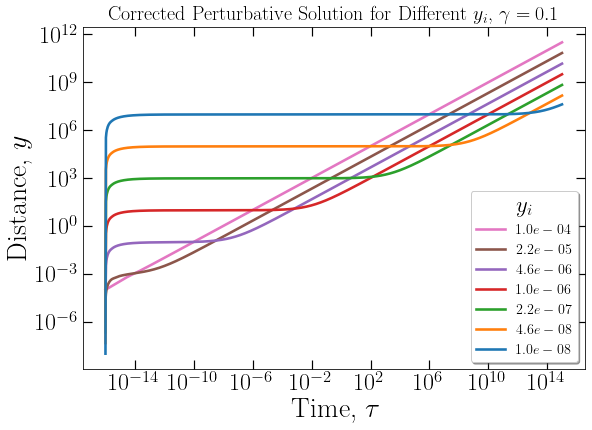

In [8]:

fig, ax = plt.subplots(figsize=(9, 6.3))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



gamma = 0.1
tau_i = 1e-16  
tau_f = 1e15
tau_arr = np.geomspace(tau_i, tau_f, 1000) 
yi_arr = np.geomspace(1e-4, 1e-8, 7)
colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']

for y_i, color in zip(yi_arr, colors):
    y_full_vals = yfull_numerical(gamma, y_i)
    t_values = yH_numerical(gamma, y_i).t
       
    ax.loglog(t_values, y_full_vals, ls='-', color=color, label=f"${y_i:.1e}$")


plt.legend(prop={'size':14.3}, loc="lower right", shadow=True, title='$y_{i}$', title_fontsize=23,
           facecolor='white', fontsize=12)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28)
plt.title(r'Corrected Perturbative Solution for Different $y_i$, $\gamma = 0.1$', fontsize=20)
plt.show()



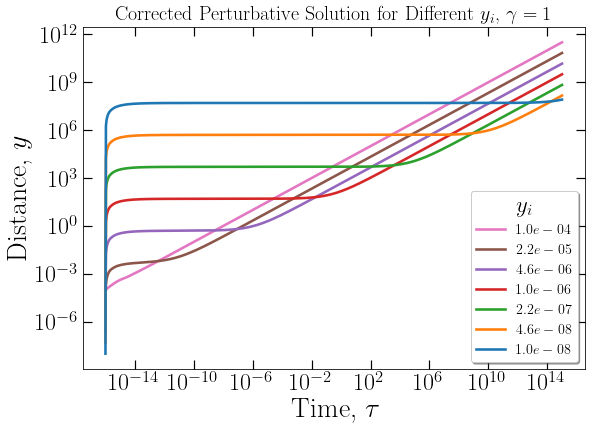

In [9]:

fig, ax = plt.subplots(figsize=(9, 6.3))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



gamma = 1
tau_i = 1e-16  
tau_f = 1e15
tau_arr = np.geomspace(tau_i, tau_f, 1000) 
yi_arr = np.geomspace(1e-4, 1e-8, 7)
colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']

for y_i, color in zip(yi_arr, colors):
    y_full_vals = yfull_numerical(gamma, y_i)
    t_values = yH_numerical(gamma, y_i).t
       
    ax.loglog(t_values, y_full_vals, ls='-', color=color, label=f"${y_i:.1e}$")


plt.legend(prop={'size':14.3}, loc="lower right", shadow=True, title='$y_{i}$', title_fontsize=23,
           facecolor='white', fontsize=12)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28)
plt.title(r'Corrected Perturbative Solution for Different $y_i$, $\gamma =1$', fontsize=20)
plt.show()

